# Yelp data analysis: Business and users' behaviour under COVID-19

## Contents

1. Executive Summary
2. Introduction 
3. Preparation
4. Data Set
5. Preliminary Analysis 
6. Sentiment Analysis
7. Execution Time
8. Conclusion
9. Reference

## 1. Executive Summary

This project aims to analyse Business and users' behaviour to help businesses under COVID-19 using Yelp Dataset.

In the Preliminary Analysis part, Spark SQL is mainly used to analyze information in four JSON files, business.json, review.json, user.json, and COVID-19.json of Yelp Dataset. For businesses dataset: there are most businesses in Austin. Besides, most businesses are in the restaurant category. There are 37337 businesses closed, which accounts for 23.23% of all businesses. With respect to ratings, most businesses get 4 stars, which means they perform relatively well. For users dataset: review_count and fans are analyzed to find the number of reviews sent by people and followings of people. Futhermore, there was a rapid increase in the number of new users from year 2004 to year 2015 and maximum growth rate of new users is in 2015, with 267516 new users. However, number of users in Yelp increased slowly in 2020 and 2021, which might caused by the COVID-19. For reviews dataset, most reviews have ratings of five stars. Also, we regards reviews with stars larger than and equal to 4 as positive reviews, reviews with stars equal to 3 as positive reviews, and the remaining reviews are negative reviews, then the percentage of each types of reviews are analysed. To adapt to the effects of COVID-19, businesses provides some extra services, such as virtual services and delivery services to operating businesses udner COVID-19.

In the Sentiment Analysis part, Latent Dirichlet Allocation(LDA) is implemented to find high frequency topics in positive and negative reviews. There is obvious different between topics in positive and negative reviews, so topics can be used to indicate sentiment of reviews. To measure the performance of LDA model, perplexity is implemented.

There is no evidence that more partitions can decrease execution time with the experiments of different query using different numbers of partitions. Too many partitions may cause scheduling problems of small tasks. Too few partitions may cause network traffic when sending and collecting data.

In conclusion, this project is a useful guide for people who are interested to learn from customers' reviews to improve their products and services and to discover target market. Furthermore, this report may be useful to discover how to operate businesses under COVID-19 providing different services, such as virtual services. At the same time, distributed computing for big data is more and more popular to discover value from large volume and wide variety of data. This project using Dataproc cluster on GCP, execute Spark SQL query and data mining algorithm using worker nodes to reduce computation time.


## 2. Introduction

This project aims to analyse information of businesses, users' behaviour and content of reviews to help businesses operating under COVID-19 using Yelp Dataset. This project mainly consists of four parts:

##### 1. Preliminary Analysis:
Spark SQL interfaced with DataFrame API is mainly used to analyze business information, user behaviour, reviews content, and COVID-19 information in four JSON files, business.json, review.json, user.json, and COVID-19.json of Yelp Dataset

##### 2. Sentiment Analysis:
Latent Dirichlet Allocation(LDA) is implemented in natural language processing to identify topic distribution of text in positive and negative reviews. Perplexity is used to measure the LDA model.

##### 3. Execution Time:
Different queries are executed using different number of partitions to examine the execution speed.



## 3. Preparation

### 3.1 Loading libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions

#from pyspark.sql.functions import udf,col
import pyspark.ml.feature as ft
from pyspark.ml.feature import *
from pyspark.context import SparkContext
from nltk.tokenize import RegexpTokenizer

import pyspark.ml.classification as cl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline


import matplotlib
import matplotlib.pyplot as plt

import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package cess_cat is already up-

[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package verbnet is already up-to-date!
[nltk_data]    | Downloading package verbnet3 to
[nltk_data]    |     /usr/local/share/

### 3.1 Google Could Platform

#### 3.1.1 Creating Bucket

#### 3.1.2 Uploading my-actions.sh to syyfinal-bucket

#### 3.1.2 Creating Cluster

## 4. Data Set

The Yelp Dataset contains 3 folders, 'JSON', 'Photos', and 'COVID-19 Data'. Five json files in folder 'JSON' and one json files in folder 'COVID-19 Data' are used in this project. There are recordings of 8,635,403 reviews, 160,585 businesses, and 2,189,457 users in Yelp Dataset.

### 4.1 JSON Folder

The size of JSON folder is 4.9GB compressed and 10.9GB uncompressed, which contains five json files: 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_user.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_checkin.json', and 'yelp_academic_dataset_tip.json'. The first three data sets are mainly used in this project.

### 4.2 COVID-19 Folder

The size of COVID-19 Data folder is 14MB compressed and 69MB uncompressed, which contains one json file: 'yelp_academic_dataset_covid_features.json'.

### 4.3 Loading Data

In [2]:
# Upload data to bucket ' syytest'

file1 = 'gs://syyfinal-bucket/yelp_academic_dataset_business.json'
file2 = 'gs://syyfinal-bucket/yelp_academic_dataset_user.json'
file3 = 'gs://syyfinal-bucket/yelp_academic_dataset_review.json'
file4 = 'gs://syyfinal-bucket/yelp_academic_dataset_checkin.json'
file5 = 'gs://syyfinal-bucket/yelp_academic_dataset_tip.json'
file6 = 'gs://syyfinal-bucket/yelp_academic_dataset_covid_features.json'


# Read files
business = spark.read.json(file1)
user = spark.read.json(file2)
review = spark.read.json(file3)
checkin = spark.read.json(file4)
tip = spark.read.json(file5)
covid = spark.read.json(file6)


### 4.4 Schema

To infer the structure of dataset, pyspark.sql.DataFrame.printSchema which can provides readable schema in tree format is used. The following tree tables show the shcema of 'business', 'user', 'review', and 'covid'.

In [5]:
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [7]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [10]:
covid.printSchema()

root
 |-- Call To Action enabled: string (nullable = true)
 |-- Covid Banner: string (nullable = true)
 |-- Grubhub enabled: string (nullable = true)
 |-- Request a Quote Enabled: string (nullable = true)
 |-- Temporary Closed Until: string (nullable = true)
 |-- Virtual Services Offered: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- delivery or takeout: string (nullable = true)
 |-- highlights: string (nullable = true)



### 4.5 Check if the amout of information matches up with the amount of information provided by Yelp Dataset.

In [11]:
# count number_of_business
business.createOrReplaceTempView("business")
no_of_business= spark.sql('Select count(*) as number_of_business from business')
no_of_business.show()


+------------------+
|number_of_business|
+------------------+
|            160585|
+------------------+



In [12]:
# count number_of_user
user.createOrReplaceTempView("user")
no_of_user = spark.sql('Select count(*) as number_of_user from user')
no_of_user.show()

+--------------+
|number_of_user|
+--------------+
|       2189457|
+--------------+



In [13]:
# count number_of_review
review.createOrReplaceTempView("review")
no_of_review=spark.sql('Select count(*) as number_of_review from review')
no_of_review.show()

+----------------+
|number_of_review|
+----------------+
|         8635403|
+----------------+



In [16]:
# count number_of_covid_information
covid.createOrReplaceTempView("covid")
no_of_covid = spark.sql('Select count(*) as number_of_covid_information from covid')
no_of_covid.show()

+---------------------------+
|number_of_covid_information|
+---------------------------+
|                     209795|
+---------------------------+



## 5. Preliminary Analysis

Spark SQL can be interfaced with SQL and DataFrame API to execute SQL queries and return results in DataFrame. 

In this section Spark SQL interfaced with DataFrame API is mainly used to analyze business information, user behaviour, reviews content, and COVID-19 information in four JSON files. Furthermore, some observations are illustrated using matplotlib.

### 5.1 Analysis on business dataset

In this section, simple queries are implemented with functions , such as count() and show(), to analysed information of businesses. Besides, results are loaded into Pandas.DataFrame.

#### 5.1.1 Anaysis on 'categories' in business dataset 

In [17]:
# select categories from business dataset rename category and group businesses within same category
# count number of businesses within same category
# sort descending
business_category=business\
.select(explode(split('categories',', ')).alias('category'))\
.groupBy('category')
business_category_count = business_category.count().sort('count', ascending=False)
dfbusiness_category_count = business_category_count.toPandas()
dfbusiness_category_count.head(10)

,category,count
0,Restaurants,50763
1,Food,29469
2,Shopping,26205
3,Beauty & Spas,16574
4,Home Services,16465
5,Health & Medical,15102
6,Local Services,12192
7,Nightlife,11990
8,Bars,10741
9,Automotive,10119


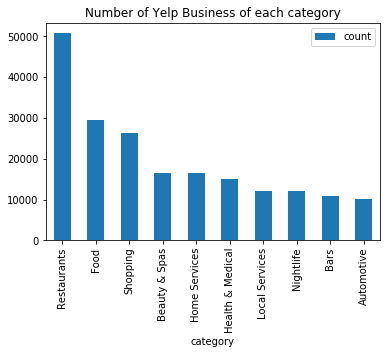

In [18]:
dfbusiness_category_count.head(10).plot.bar(x = 'category',\
                                            y = 'count', title='Number of Yelp Business of each category')

##### Query observations:
From obervations above, highest number of businesses belongs to category of restaurants in Yelp Dataset.

#### 5.1.2 Anaysis on 'city' in business dataset

In [19]:
# select city from business dataset and group businesses within same city
# count number of businesses within same city
# sort descending
business_city=business.groupBy('city')
business_city_count=business_city.count().sort('count', ascending=False)
dfbusiness_city_count = business_city_count.toPandas()
dfbusiness_city_count.head(10)

,city,count
0,Austin,22416
1,Portland,18203
2,Vancouver,13330
3,Atlanta,12612
4,Orlando,10637
5,Boston,8263
6,Columbus,6634
7,Boulder,2542
8,Cambridge,2433
9,Beaverton,2252


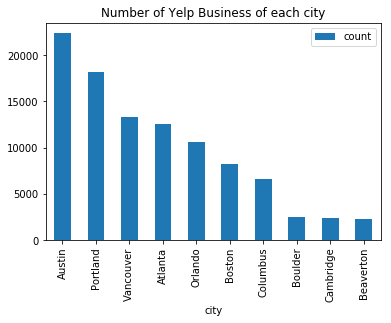

In [20]:
dfbusiness_city_count.head(10).plot.bar(x = 'city', y = 'count', title='Number of Yelp Business of each city')

##### Query observations:
From obervations above, Austin has the most businesses in the Yelp Dataset.

#### 5.1.3 Anaysis on 'is_open' in business dataset

In [21]:
## filter open businesses from business dataset
# count number of open businesses 
# sort descending
business_open=business.filter(business.is_open == '1').alias('open')
business_open_count = business_open.count()
business_open_count


123248

In [22]:
## filter closed businesses from business dataset
# count number of closed businesses 
# sort descending
business_closed=business.filter(business.is_open == '0').alias('closed')
business_closed_count = business_closed.count()
business_closed_count


37337

In [23]:
business_open_closed = business.groupBy('is_open')
business_open_closed_count = business_open_closed.count().sort('count', ascending=False)
dfbusiness_open_closed_count = business_open_closed_count.toPandas()
dfbusiness_open_closed_count = dfbusiness_open_closed_count.set_index('is_open')
dfbusiness_open_closed_count

,count
is_open,
1,123248
0,37337


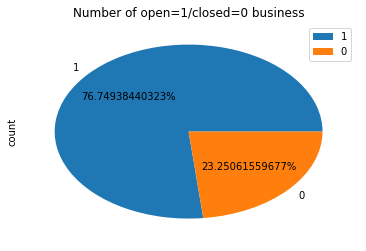

In [24]:
dfbusiness_open_closed_count.plot.pie( y = 'count', title='Number of open=1/closed=0 business',autopct='%1.11f%%')

##### Query observations:
Almost 23.3% of businesses are closed until now in Yelp Dataset.

#### 5.1.4 Anaysis on 'stars' in business dataset

In [25]:
# group businesses has same stars
# count number of businesses with same stars
# sort with stars descending
business_star=business.groupBy('stars').count().sort('stars', ascending=False)
dfbusiness_star = business_star.toPandas()
dfbusiness_star

,stars,count
0,5.0,19953
1,4.5,28072
2,4.0,34056
3,3.5,28835
4,3.0,21583
5,2.5,13720
6,2.0,8523
7,1.5,4157
8,1.0,1686


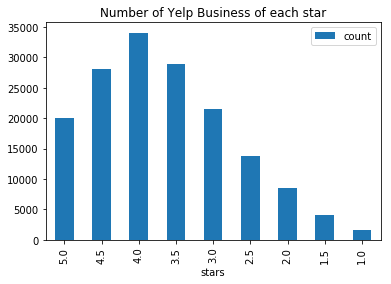

In [26]:
dfbusiness_star = dfbusiness_star
dfbusiness_star.plot.bar(x = 'stars', y='count', title='Number of Yelp Business of each star')


##### Query observations:
Most of businesses are rated 4 stars and most businesses perform well with high ratings (>3).

#### 5.1.5 Anaysis on 'state' in business dataset

In [27]:
## group businesses within same state
# count number of businesses within same state
# sort with count descending
business_state=business.groupBy('state').count().sort('count', ascending=False)
dfbusiness_state = business_state.toPandas()
dfbusiness_state.head(10)

,state,count
0,MA,36012
1,OR,25175
2,TX,24485
3,FL,21907
4,GA,18090
5,BC,17298
6,OH,11258
7,CO,3198
8,WA,3121
9,CA,13


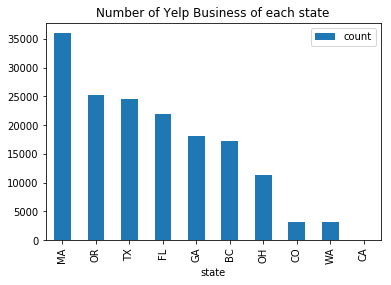

In [28]:
dfbusiness_state.head(10).plot.bar(x = 'state', y='count', title='Number of Yelp Business of each state')

##### Query observations:
From obervations above, Massachusetts has the most businesses of all states in the Yelp Dataset.

### 5.2 Analysis on user dataset

In this section, some information of user are analysed.

#### 5.2.1 Anaysis on 'yelping_since' in user dataset

 withColumn() is implemented to add new column in dataframe.

In [31]:
user_since = user.select('user_id', 'yelping_since')
user_since= user_since.withColumn('year', split(user_since['yelping_since'], '[- :]').getItem(0)) \
       .withColumn('month', split(user_since['yelping_since'], '[- :]').getItem(1)) \
       .withColumn('day', split(user_since['yelping_since'], '[- :]').getItem(2))\
        .withColumn('hour', split(user_since['yelping_since'], '[- :]').getItem(3))\
        .withColumn('minute', split(user_since['yelping_since'], '[- :]').getItem(4))\
        .withColumn('second', split(user_since['yelping_since'], '[- :]').getItem(5)) \
        .sort(asc('year'),asc('month'),asc('day'),asc('hour'), asc('minute'),asc('second'))
dfuser_since=user_since.toPandas()
dfuser_since.head(10)

,user_id,yelping_since,year,month,day,hour,minute,second
0,fFGPBtsutYpn3A155Sf75Q,2004-10-12 08:46:11,2004,10,12,08,46,11
1,nkN_do3fJ9xekchVC-v68A,2004-10-12 08:46:43,2004,10,12,08,46,43
2,RU7bd3h2f6pBlf8BfAyxGQ,2004-10-12 08:47:20,2004,10,12,08,47,20
3,wqoXYLWmpkEH0YvTmHBsJQ,2004-10-12 08:51:07,2004,10,12,08,51,07
4,iiruNMRBWMdxqRtaVIMPkA,2004-10-12 09:17:53,2004,10,12,09,17,53
5,9549vDBw7ab0cuc930BQ1g,2004-10-12 10:00:59,2004,10,12,10,00,59
6,23J4vG9_xxxdnmi8CBX7Ng,2004-10-12 12:29:35,2004,10,12,12,29,35
7,LFLpi-FfgDW4zpcdz3hfSQ,2004-10-12 13:27:53,2004,10,12,13,27,53
8,xIYFwwrwxSFyz1IjVfHTkg,2004-10-12 14:10:17,2004,10,12,14,10,17
9,KKOM5feU4TzZmUEY24y02Q,2004-10-12 14:42:04,2004,10,12,14,42,04


##### Query observations:
Yelp was founded in 2004 and the first user joined Yelp at 08:46:11 on 12 October, 2004.

In [32]:
user_join = user_since.groupBy('year').count().sort('year')
dfuser_join = user_join.toPandas()
dfuser_join

,year,count
0,2004,126
1,2005,1615
2,2006,8218
3,2007,23911
4,2008,47701
5,2009,94315
6,2010,148041
7,2011,224158
8,2012,233502
9,2013,242864


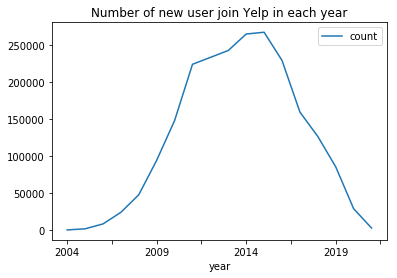

In [33]:
dfuser_join.plot.line(x = 'year', y='count', title='Number of new user join Yelp in each year')

##### Query observations:
There was a rapid increase in the number of new users from year 2004 to year 2015 and maximum growth rate of new users is in 2015, with 267516 new users. After 2015, fewer and fewer new users joined Yelp in each year. In 2020, new users is 28835, which is a one third of 2019. This might be caused by the COVID-19.

#### 5.2.2 Anaysis on 'friends' in user dataset

In [34]:
user_friends = user.select('friends')
user_friends = user_friends.withColumn('userid', explode(split(col('friends'), ',')))\
    .groupBy('userid')\
    .count()\
    .sort('count', ascending=False)\
    .show(10,False)
#dfuser_friends = user_friends.toPandas()
#dfuser_friends.head(10)
  

+-----------------------+------+
|userid                 |count |
+-----------------------+------+
|None                   |956004|
| Oi1qbcz2m2SnwUeztGYcnQ|6328  |
| qVc8ODYU5SZjKXVBgXdI7w|4448  |
| hizGc5W1tBHPghM5YKCAtg|4363  |
| JjXuiru1_ONzDkYVrHN0aw|4359  |
| YttDgOC9AlM4HcAlDsbB2A|4339  |
| 8lEywHSvti2UjFP8ODbnHg|4231  |
| mV4lknblF-zOKSF8nlGqDA|4227  |
| hdzTAN8DGJKRddkZ8279JQ|4167  |
| lZbotco47bHU7oE5b3d1DA|4164  |
+-----------------------+------+
only showing top 10 rows



##### Query observations:
There are 956004 yelp users who have no friend relationship with other yelp user.

### 5.3 Analysis on review dataset

In this section, some information of reviews is analysed.

#### 5.3.1 Analysis on 'stars' in review dataset

In [35]:
review_stars = review.groupBy('stars').count().sort('stars')
dfreview_stars = review_stars.toPandas()
dfreview_stars


,stars,count
0,1.0,1262800
1,2.0,711378
2,3.0,926656
3,4.0,1920037
4,5.0,3814532


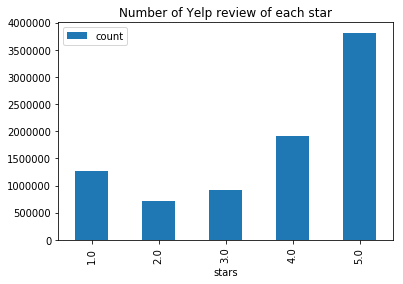

In [36]:
dfreview_stars.plot.bar(x = 'stars', y='count', title='Number of Yelp review of each star')

##### Query observations:
Most of reviews has a 4-star and 5-star rating for businesses. Besides, Reviews with 5-star is almost twice as many as reviews with 4-star, in Yelp Dataset.

#### 5.3.2 Analysis on 'review_count' in review dataset

Following query is used to identify number of reviews written for each business 

In [5]:
business_id = business.select('business_id')
review_business_id = review.select('business_id')

# join business and review with same business id
join_business_review = business.select('business_id','name','city').join(review_business_id,'business_id','inner')

# total number of reviews of each business
review_count = join_business_review.groupBy('business_id').count().sort('count',ascending = False)
review_count = review_count.withColumnRenamed('count','total_reviews')
dfreview_count = review_count.toPandas()
dfreview_count.head(10)
#dfreview_count.head(10).plot.bar(x = 'business_id', y='count', title='Number of Yelp review of each star')

,business_id,total_reviews
0,4CxF8c3MB7VAdY8zFb2cZQ,9295
1,OQ2oHkcWA8KNC1Lsvj1SBA,7394
2,PrsvO1rzkgg6qFizlAoEtg,7385
3,zioLxtBc9THNS2TOn9xW1w,6325
4,y2w6rFaO0XEiG5mFfOsiFA,5220
5,MGzro82Fi4LYvc86acoONQ,5071
6,cs6HfZNykLVitm09jWFqWg,4901
7,bZiIIUcpgxh8mpKMDhdqbA,4818
8,qLJUDPOamhLdbtfbcWyHnA,4628
9,n73rxa6e6-fTIxQzfv4BuA,4560


#### 5.3.3 Analysis on positive, neutral, and negative review

Businesses should pay attention to both positive and negative reviews to improve their products and service to retain returned customers and attract new customers.

A.  Number of positive reviews for each businesses and the percentage of positive reviews.

In [6]:
#business_id = business.select('business_id')

# regard stars >= 4 as positive review
review_star_positive = review.filter('stars >=4')
business_star_positive = business_id.join(review_star_positive,'business_id','inner')

# number of star >= 4 for each business
review_group_positive = business_star_positive.groupBy('business_id').count()
review_positive = business.select('business_id','name','city').join(review_group_positive,'business_id','inner')
review_positive = review_positive.withColumnRenamed("count", "positive_reviews")

# join review table and positive review table
review_positive = review_positive.join(review_count,'business_id','inner')\
.distinct().sort('positive_reviews', ascending = False).limit(100)
dfreview_positive=review_positive.toPandas()
#dfreview_positive.head(10)

# top 10 businesses with highest percentage of positive rate of top 100 businesses with most number of review
review_positive_percentage = review_positive\
.withColumn('percentage of positive reviews', (col('positive_reviews')/col('total_reviews'))*100)\
.sort('percentage of positive reviews',ascending = False)
dfreview_positive_percentage = review_positive_percentage.toPandas()
dfreview_positive_percentage.head(10)

,business_id,name,city,positive_reviews,total_reviews,percentage of positive reviews
0,BSUDAiXd50PAkfFAztVpDw,Aviva by Kameel,Atlanta,1511,1565,96.549521
1,OPfgKOm_n-ajUo3qjSEgRg,Powell's City of Books,Portland,4148,4332,95.752539
2,MVm6pgnnd6Sg_LdtUhkGuw,Pip's Original Doughnuts & Chai,Portland,2370,2539,93.343836
3,S9NvWyHUPsuYK7ObMV43pA,Desta Ethiopian Kitchen,Atlanta,1643,1803,91.125901
4,IyLLref8p5xTcuO7SpHf-g,Salt & Straw,Portland,1587,1745,90.945559
5,EqUqaLJxMDxIqvnmaKB4Lw,Portland International Airport - PDX,Portland,1972,2200,89.636364
6,o_L9Ss4boqq6ZEF9xeSH6Q,Salt & Straw,Portland,3320,3721,89.223327
7,MGzro82Fi4LYvc86acoONQ,Franklin Barbecue,Austin,4465,5071,88.049694
8,32hFMl7d-243oMULkn84VQ,The Waffle Window,Portland,1500,1707,87.873462
9,GJxFtnTqTiokFedNrW9iDQ,Atlanta Breakfast Club,Atlanta,3352,3816,87.840671


##### Query observations:
Most of top 10 businesses with highest percentage of positive reviews are from Atlanta and Portland and the percentages of positive reviews of these businesses are all larger than 85%, which means they provide good products and services to their customers in Yelp Dataset.

B.  Number of neutral reviews for each businesses and the percentage of positive reviews.

In [7]:
#business_id = business.select('business_id')

# regard stars =3 as neutral review
review_star_neutral = review.filter('stars = 3')
business_star_neutral = business_id.join(review_star_neutral,'business_id','inner')

# number of star =3 for each business
review_group_neutral = business_star_neutral.groupBy('business_id').count()
review_neutral = business.select('business_id','name','city').join(review_group_neutral,'business_id','inner')
review_neutral = review_neutral.withColumnRenamed('count', 'neutral_reviews')

# join review table and neutral review table
review_neutral = review_neutral.join(review_count,'business_id','inner')\
.distinct().sort('neutral_reviews', ascending = False).limit(100)
dfreview_neutral=review_neutral.toPandas()
#dfreview_neutral.head(10)

# top 10 businesses with highest percentage of neutral rate of top 100 businesses with most number of review
review_neutral_percentage = review_neutral\
.withColumn('percentage of neutral reviews', (col('neutral_reviews')/col('total_reviews'))*100)\
.sort('percentage of neutral reviews',ascending = False)
dfreview_neutral_percentage = review_neutral_percentage.toPandas()
dfreview_neutral_percentage.head(10)


,business_id,name,city,neutral_reviews,total_reviews,percentage of neutral reviews
0,vITc1UkWLvG9pVdaOxyCnA,Boston Logan International Airport - BOS,Boston,519,1601,32.417239
1,JwJa6nY_wlZEjagVleWQ-Q,Cheers,Boston,271,971,27.909372
2,vxihRQq1lzr11W7ReS7bMA,New England Aquarium,Boston,249,928,26.831897
3,2PxZ-fICnd432NJHefXrcA,Orlando International Airport - MCO,Orlando,709,2709,26.172019
4,hzSyQBWeoX94WOpUtxuWVg,Mr. Bartley's Gourmet Burgers,Cambridge,324,1271,25.491739
5,sPhPI3B6tvcJIULhICr-Pg,The Varsity,Atlanta,517,2098,24.642517
6,oz882XuZCxajKo64Opgq_Q,Barking Crab,Boston,522,2180,23.944954
7,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,2167,9295,23.313609
8,MwXqRRjjpwKoEKZBb78ScQ,World of Coca-Cola,Atlanta,364,1617,22.510823
9,7sxYa0-TwWeWGFr5CvMMkw,Hartsfield-Jackson Atlanta International Airpo...,Atlanta,920,4088,22.504892


##### Query observations:
Compared with the top 10 percentage of positive reviews or negative reviews, top 10 percentage of neutral reviews are relatively low, which might mean customers who are satisfied or not satisfied with products or services are willing to leave their reviews in Yelp Dataset.

C.  Number of negative reviews for each businesses and the percentage of positive reviews.

In [8]:
#business_id = business.select('business_id')

# regard stars <=2 as neutral review
review_star_negative = review.filter('stars <= 2')
business_star_negative = business_id.join(review_star_negative,'business_id','inner')

# number of star =3 for each business
review_group_negative = business_star_negative.groupBy('business_id').count()
review_negative = business.select('business_id','name','city').join(review_group_negative,'business_id','inner')
review_negative = review_negative.withColumnRenamed('count', 'negative_reviews')

# join review table and neutral review table
review_negative = review_negative.join(review_count,'business_id','inner')\
.distinct().sort('negative_reviews', ascending = False).limit(100)
dfreview_negative=review_negative.toPandas()
#dfreview_negative.head(10)

# top 10 businesses with highest percentage of neutral rate of top 100 businesses with most number of review
review_negative_percentage = review_negative\
.withColumn('percentage of negative reviews', (col('negative_reviews')/col('total_reviews'))*100)\
.sort('percentage of negative reviews',ascending = False)
dfreview_negative_percentage = review_negative_percentage.toPandas()
dfreview_negative_percentage.head(10)

,business_id,name,city,negative_reviews,total_reviews,percentage of negative reviews
0,kmtmY04UpdCfWz7sZI6V2w,Avas Flowers,Austin,772,780,98.974359
1,hpibqRJSGhacWpQFZJZbaQ,Vivint Smart Home,Austin,605,621,97.423510
2,aRY3fdEgWRH-l0llFnDY5w,Economy Rent a Car,Orlando,790,821,96.224117
3,yEUy4iifAVtbNbUe9isKVA,Newgistics,Austin,402,418,96.172249
4,U7spOEyi0TevjuhF-e-9PQ,HomeAway,Austin,534,558,95.698925
5,8yX7VHwmrh6ZGF24yzGr4w,Signature Rent A Car,Orlando,512,545,93.944954
6,CpLGxwK7wiUwZ5EtVc0fXA,XFINITY,Boston,335,358,93.575419
7,PKTzqvKrdX-EC__PfUIJoA,Green Motion Car and Van Rental,Orlando,527,576,91.493056
8,qvD05l6Q2Inz-NMCAemyKQ,Spectrum,Austin,729,798,91.353383
9,8NDk1mGHRwHpV7nL9P-tqQ,LaserShip,Woburn,533,586,90.955631


##### Query observations:
Half of top 10 businesses with highest percentage of negative reviews are from Austin and the percentages of positive reviews of these top 10 businesses are all larger than 90%, which means they provide bad products and services to their customers in Yelp Dataset.

### 5.4 Analysis on covid dataset

The COVID-19 data set is released on June 10, 2020 to help businesses connect to their customers, which contains actions to keep businesses operating under Covid-19, such as virtual services.

#### 5.4.1 Analysis on 'temporary closed until' in covid dataset

In [44]:
temporary_closed = covid.select('business_id', 'Temporary Closed Until').distinct().groupBy('Temporary Closed Until').count()
temporary_closed= temporary_closed.withColumn('year', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(0)) \
       .withColumn('month', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(1)) \
       .withColumn('day', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(2))\
        .withColumn('hour', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(3))\
        .withColumn('minute', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(4))\
        .withColumn('second', split(temporary_closed['Temporary Closed Until'], '[- : T z]').getItem(5)) \
        .sort(desc('count'))
dftemporary_closed=temporary_closed.toPandas()
dftemporary_closed.head(20)

,Temporary Closed Until,count,year,month,day,hour,minute,second
0,FALSE,208014,FALSE,None,None,None,None,None
1,2020-07-01T00:00:00.000Z,331,2020,07,01,00,00,00.000Z
2,2020-06-15T00:00:00.000Z,261,2020,06,15,00,00,00.000Z
3,2020-06-30T00:00:00.000Z,172,2020,06,30,00,00,00.000Z
4,2020-08-01T00:00:00.000Z,133,2020,08,01,00,00,00.000Z
5,2020-08-31T00:00:00.000Z,43,2020,08,31,00,00,00.000Z
6,2020-10-01T00:00:00.000Z,36,2020,10,01,00,00,00.000Z
7,2020-07-31T00:00:00.000Z,31,2020,07,31,00,00,00.000Z
8,2020-06-16T00:00:00.000Z,29,2020,06,16,00,00,00.000Z
9,2021-01-04T00:00:00.000Z,27,2021,01,04,00,00,00.000Z


##### Query observations:
Most of businesses were reopening during summer in 2020. However, some businesses chose to reopen later in 2021 in Yelp Dataset.

#### 5.4.2 Analysis on 'Call To Action enabled', 'Grubhub enabled', 'delivery or takeout' in covid dataset

In [45]:
call_to_action = covid.select('Call To Action enabled').groupBy('Call To Action enabled').count()
dfcall_to_action = call_to_action.toPandas()
dfcall_to_action

,Call To Action enabled,count
0,FALSE,155728
1,TRUE,54067


In [46]:
grubhub = covid.select('Grubhub enabled').groupBy('Grubhub enabled').count()
dfgrubhub = grubhub.toPandas()
dfgrubhub

,Grubhub enabled,count
0,FALSE,191802
1,TRUE,17993


In [14]:
delivery = covid.select('delivery or takeout').groupBy('delivery or takeout').count()
dfdelivery = delivery.toPandas()
dfdelivery.head()

,delivery or takeout,count
0,FALSE,143564
1,TRUE,66231


##### Query observations:
Most of businesses have not used the 'Call To Action ' button and not partnered with Grubhub. At the same time, only one third businesses provides service of delivery or takeout in Yelp Dataset.

#### 5.4.3 Analysis on 'Virtual Services Offered' in covid dataset

In [48]:
virtual = covid.select('Virtual Services Offered').groupBy('Virtual Services Offered').count()
dfvirtual = virtual.toPandas()
dfvirtual.head()

,Virtual Services Offered,count
0,FALSE,205573
1,offers_virtual_office_space,1
2,offers_virtual_tasting_sessions,18
3,offers_virtual_experiences,24
4,offers_virtual_tours,821


##### Query observations:
There are four kinds of virtual services offered by businesses and the most common one is virtual tours. However, most of businesses do not provide virtual services in Yelp Dataset.

#### 5.4.4 Analysis on 'Request a Quote Enabled' in covid dataset

In [15]:
quote = covid.select('Request a Quote Enabled').groupBy('Request a Quote Enabled').count()
dfquote = quote.toPandas()
dfquote.head()

,Request a Quote Enabled,count
0,FALSE,207347
1,TRUE,2448


##### Query observations:
Only 2448 businesses still has 'Request a Quote' enabled.

## 6. Sentiment Analysis


In this section, sentiment analysis is implemented to analyse the sentiment of users' reviews. Latent Dirichlet Allocation(LDA) is implemented to identify topics distribution of positive and negative reviews.

### 6.1Positive, Neutral, and Negative reviews

Reviews with star > 3: positive reviews 

Reviews with star = 3: neutral reviews 

Reviews with star < 3: negative reviews 

In [4]:
# classification of sentiment of reviews
def sentiment_review (stars):
    if stars >3:
        return 'Positive'
    elif stars ==3:
        return 'Neutral'
    else:
        return 'Negative'

# user defined function
udfsentiment_review = functions.udf(sentiment_review,StringType())

### 6.2 Identifying topics with high frequency in reviews of different sentiment using Latent Dirichlet Allocation 

#### 1. Latent Dirichlet Allocation (LDA) :

LDA is a statistical method which can be used to explain the similarity of some parts of data. 

In machine learning, LDA is can be used in natural language processing to do topic modelling to classify relevant individual document in a collection. Consequently, LDA is used to find topics in both positive and negative reviews.

#### 2. Topic modelling: 

Topic modelling is used to identify frequency words in a topic, which can be implemented to group different words together and discover similar topics in different documents.

#### 3. Measurement:
Perplexity is used as measurment of how well a probability model used to predicts a sample, which can be used to compare probability models. A high perplexity indicates that the probability model cannot predict a sample accurately. Consequtly, a probability model with lower perplexity is preferred.


#### 4. Implementaton: 

LDA is implemented in reiview data set to identify topic distribution of text in positive and negative reviews.


###### Reviews with Sentiment

In [5]:
review_sentiment = review.select('review_id','stars','text')\
.withColumn('Sentiment', udfsentiment_review('stars'))
review_sentiment.show(5)

+--------------------+-----+--------------------+---------+
|           review_id|stars|                text|Sentiment|
+--------------------+-----+--------------------+---------+
|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...| Positive|
|8bFej1QE5LXp4O05q...|  4.0|This store is pre...| Positive|
|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...| Positive|
|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...| Negative|
|sjm_uUcQVxab_EeLC...|  4.0|The food is alway...| Positive|
+--------------------+-----+--------------------+---------+
only showing top 5 rows



###### Positive review

In [6]:
positive_review = review_sentiment.filter(review_sentiment.Sentiment== 'Positive')
positive_review.show(5)

+--------------------+-----+--------------------+---------+
|           review_id|stars|                text|Sentiment|
+--------------------+-----+--------------------+---------+
|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...| Positive|
|8bFej1QE5LXp4O05q...|  4.0|This store is pre...| Positive|
|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...| Positive|
|sjm_uUcQVxab_EeLC...|  4.0|The food is alway...| Positive|
|9vqwvFCBG3FBiHGmO...|  5.0|Probably one of t...| Positive|
+--------------------+-----+--------------------+---------+
only showing top 5 rows



###### Neutral review

In [7]:
neutral_review = review_sentiment.filter(review_sentiment.Sentiment== 'Neutral')
neutral_review.show(5)

+--------------------+-----+--------------------+---------+
|           review_id|stars|                text|Sentiment|
+--------------------+-----+--------------------+---------+
|GgWFjRHhelaiUgR2-...|  3.0|3.5 stars! I got ...|  Neutral|
|oNNTEpc2PmB4w_vy9...|  3.0|"A Bit Embarrasse...|  Neutral|
|ADPWjsySIpmuOSL07...|  3.0|Just had Yalla fo...|  Neutral|
|P320Yt8vFD3yjI34h...|  3.0|Overall is good, ...|  Neutral|
|ljjT3RaKYLWZOwdWB...|  3.0|Bummer that the p...|  Neutral|
+--------------------+-----+--------------------+---------+
only showing top 5 rows



###### Negative review

In [8]:
negative_review = review_sentiment.filter(review_sentiment.Sentiment== 'Negative')
negative_review.show(5)

+--------------------+-----+--------------------+---------+
|           review_id|stars|                text|Sentiment|
+--------------------+-----+--------------------+---------+
|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...| Negative|
|J4a2TuhDasjn2k3wW...|  1.0|This place used t...| Negative|
|28gGfkLs3igtjVy61...|  2.0|The setting is pe...| Negative|
|FdoBFTjXXMn4hVnJ5...|  1.0|They NEVER seem t...| Negative|
|Qv_lQb1Yu9DGsUO3r...|  2.0|Disappointing. Bo...| Negative|
+--------------------+-----+--------------------+---------+
only showing top 5 rows



### 6.2.1 Implementation of LDA
LDA is implemented to discover topics in Positive and Negative reviews, because it is useful for merchants to identify how to improve their products and services to increase profits.

### 1) Positive reviews

In [9]:
# rdd of positive_review
positive_review_rdd = positive_review.rdd

# text column
positive_review_rdd = positive_review_rdd.map(lambda x : x['text'])

#### Parse the data

nltk: natural language processing module used for tokenisation and lemmatisation

Tokenisation: splitting text into individual words

Lemmatisation: grouping inflected words together to produce dictionary form


In [10]:
# Quote from Week09 LDA.ipynb
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english')) 
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

def get_tokens(line):
    
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

positive_words_rdd = positive_review_rdd.map(lambda line: (1, get_tokens(line)))
positive_words_rdd.take(1)

[(1,
  ['apparently',
   'pride',
   'osteria',
   'rough',
   'summer',
   'evidenced',
   'almost',
   'empty',
   'dining',
   'room',
   'friday',
   'night',
   'however',
   'new',
   'blood',
   'kitchen',
   'seems',
   'revitalized',
   'food',
   'customer',
   'recent',
   'visit',
   'waitstaff',
   'warm',
   'unobtrusive',
   'pm',
   'left',
   'bar',
   'full',
   'dining',
   'room',
   'much',
   'lively',
   'perhaps',
   'beverly',
   'resident',
   'prefer',
   'later',
   'seating',
   'reading',
   'mixed',
   'review',
   'late',
   'little',
   'tentative',
   'choice',
   'luckily',
   'nothing',
   'worry',
   'food',
   'department',
   'started',
   'fried',
   'dough',
   'burrata',
   'prosciutto',
   'lovely',
   'although',
   'nt',
   'offer',
   'half',
   'portion',
   'pasta',
   'ordered',
   'entree',
   'size',
   'split',
   'chose',
   'tagliatelle',
   'bolognese',
   'four',
   'cheese',
   'filled',
   'pasta',
   'creamy',
   'sauce',
   'b

Assume words appear more than 10000 times are stop words

In [ ]:
doc_stop_words = positive_words_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# doc_stop_words.collect()

doc_stop_words = doc_stop_words.filter(lambda a: a[1]>10000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
positive_words_rdd = positive_words_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1])) 

positive_words_rdd.take(1)[0][1][:10]

['osteria',
 'evidenced',
 'revitalized',
 'unobtrusive',
 'beverly',
 'tentative',
 'burrata',
 'tagliatelle',
 'bolognese',
 'grana']

#### Convert tokens into sparse vectors

CountVectorizer is a tool, which can be used to transform text into a vector based on the frequency of each word. The histograms of word counts of each document is generated.


In [ ]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

positive_words_df = spark.createDataFrame(positive_words_rdd, ["dummy","words"])
positive_words_df.cache()
positive_words_df.take(1)

[Row(dummy=1, words=['osteria', 'evidenced', 'revitalized', 'unobtrusive', 'beverly', 'tentative', 'burrata', 'tagliatelle', 'bolognese', 'grana', 'frita', 'secondo', 'berkshire', 'secreto', 'skirt', 'purée', 'romanesco', 'incorrectly', 'romanesco', 'capable', 'tenant', 'basketball', 'intervened', 'comped', 'naysayer', 'glory', 'october'])]

In [ ]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(positive_words_df)

positive_words_df_w_features = cv_model.transform(positive_words_df)
positive_words_df_w_features.cache()
positive_words_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[osteria, evidenc...|(262144,[165,500,...|
|    1|[walmart, milford...|(262144,[63,911,1...|
|    1|[wvm, evan, cody,...|(262144,[582,4072...|
|    1|              [snag]|(262144,[953],[1.0])|
|    1|[eggmeatmuffin, l...|(262144,[761,1885...|
|    1|[authority, tenni...|(262144,[589,1468...|
|    1|       [pru, chowda]|(262144,[6383,930...|
|    1|[flip, venison, s...|(262144,[204,517,...|
|    1|[fivestar, mauric...|(262144,[462,983,...|
|    1|[ufc, fight, rest...|(262144,[84,611,6...|
+-----+--------------------+--------------------+
only showing top 10 rows



#### Vocabulary

Vocabulary is stored separately using cv_model from the histograms of words for each document.

In [ ]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])
print("\n---\n")

W = len(cv_model.vocabulary)
print("Number of terms W = ", W)

Vocabulary from CountVectorizerModel is:
['quinoa', 'ha', 'receipt', 'appears', 'greater', 'alfredo', 'citrus', 'overpowering', 'lean', 'lil', 'pricier', 'mixture', 'trivia', 'painted', 'checkin', 'mexico', 'cab', 'rated', 'remove', 'naturally', 'frill', 'greeting', 'brulee', 'mug', 'cigar', 'magazine', 'female', 'oak', 'sorbet', 'exquisite', 'kidding', 'blackened', 'baklava', 'operation', 'dipped', 'ryan', 'mignon', 'efficiently', 'prop', 'mill', 'fabric', 'cranberry', 'reached', 'canada', 'convinced', 'glaze', 'toward', 'jim', 'speedy', 'iphone', 'addicted', 'code', 'sock', 'smoking', 'reserve', 'estate', 'ship', 'scramble', 'featured', 'pressed', 'retail', 'surely', 'halibut', 'checkout', 'journey', 'au', 'bottled', 'thousand', 'accommodated', 'breath', 'relationship', 'answering', 'vermicelli', 'essentially', 'stretch', 'fed', 'marinara', 'sheet', 'hoped', 'fireplace', 'endless', 'european', 'michelle', 'topnotch', 'fight', 'dense', 'desired', 'effect', 'lip', 'heated', 'listens', 

#### Latent Dirichlet Allocation

Using Latent Dirichlet Allocation to analyse positive_review with k=20.

In [ ]:
from pyspark.ml.clustering import LDA

lda = LDA(k=20, maxIter=5)

lda_model = lda.fit(positive_words_df_w_features)

#### Measurement:

In [ ]:
ll = lda_model.logLikelihood(positive_words_df_w_features)

lp = lda_model.logPerplexity(positive_words_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))

In [18]:
# Describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")

#topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics described by their top-weighted terms:
['roti' 'birth' 'turkish' 'rachel' 'ethiopian']
['mein' 'gun' 'char' 'kebab' 'dietary']
['harry' 'papaya' 'potter' 'cruise' 'laura']
['nom' 'zoo' 'extension' 'kong' 'honda']
['chiropractor' 'tiger' 'chiropractic' 'adjustment' 'guitar']
['fence' 'gumbo' 'comic' 'tim' 'sorbet']
['mahi' 'jimmy' 'paella' 'bra' 'peruvian']
['alfredo' 'publix' 'marinara' 'hookah' 'ryan']
['ashley' 'brulee' 'froyo' 'oak' 'april']
['tint' 'nicole' 'metro' 'hollywood' 'barbacoa']
['fabric' 'pok' 'alteration' 'bride' 'verde']
['cobbler' 'biryani' 'chutney' 'chick' 'cheesesteak']
['cigar' 'piercing' 'peter' 'latin' 'walmart']
['bahn' 'float' 'rooftop' 'dosa' 'boneless']
['jasmine' 'trivia' 'puzzle' 'tso' 'mignon']
['franklin' 'appt' 'torchy' 'bravas' 'monte']
['sichuan' 'lac' 'arepas' 'shane' 'luc']
['vermicelli' 'defiantly' 'powell' 'anthony' 'taiwanese']
['earl' 'blackened' 'quiche' 'threading' 'grey']
['gyoza' 'costco' 'customize' 'migas' 'ikea']


### 2) Negative reviews

In [21]:
# rdd of negative_review
negative_review_rdd = negative_review.rdd

# text column
negative_review_rdd = negative_review_rdd.map(lambda x : x['text'])

#### Parse the data

In [22]:
negative_words_rdd = negative_review_rdd.map(lambda line: (1, get_tokens(line)))
negative_words_rdd.take(1)

[(1,
  ['stayed',
   'many',
   'marriott',
   'renaissance',
   'marriott',
   'huge',
   'disappointment',
   'front',
   'desk',
   'atrium',
   'nice',
   'starbucks',
   'site',
   'nice',
   'room',
   'run',
   'old',
   'flat',
   'screen',
   'expected',
   'renaissance',
   'got',
   'hotel',
   'via',
   'priceline',
   'rate',
   'good',
   'deal',
   'price',
   'true',
   'renaissance'])]

In [ ]:
doc_stop_words2 = negative_words_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# doc_stop_words.collect()

doc_stop_words2 = doc_stop_words2.filter(lambda a: a[1]>10000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
negative_words_rdd = negative_words_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1])) 
negative_words_rdd.take(1)[0][1][:10]

['marriott',
 'renaissance',
 'marriott',
 'atrium',
 'renaissance',
 'priceline',
 'renaissance']

#### Convert tokens into sparse vectors

In [ ]:
negative_words_df = spark.createDataFrame(negative_words_rdd, ["dummy","words"])
negative_words_df.cache()
negative_words_df.take(1)

[Row(dummy=1, words=['marriott', 'renaissance', 'marriott', 'atrium', 'renaissance', 'priceline', 'renaissance'])]

In [27]:
cv2 = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model2 = cv2.fit(negative_words_df)

negative_words_df_w_features = cv_model2.transform(negative_words_df)
negative_words_df_w_features.cache()
negative_words_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[marriott, renais...|(180283,[600,2362...|
|    1|[neanderthal, bou...|(180283,[200,449,...|
|    1|[adequate, victor...|(180283,[530,3240...|
|    1|[crappy, inconsis...|(180283,[40,314,4...|
|    1|[bolt, fanny, fab...|(180283,[17,218,4...|
|    1|[taker, incompete...|(180283,[3,26,82,...|
|    1|            [vacant]|(180283,[2641],[1...|
|    1|[desolate, dingy,...|(180283,[81,1010,...|
|    1|[coco, harm, foul...|(180283,[69,165,3...|
|    1|[soccer, understa...|(180283,[309,838,...|
+-----+--------------------+--------------------+
only showing top 10 rows



#### Vocabulary

In [28]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model2.vocabulary[:100])
print("\n---\n")

W2 = len(cv_model2.vocabulary)
print("Number of terms W2 = ", W2)

Vocabulary from CountVectorizerModel is:
['refund', 'unprofessional', 'disgusting', 'refused', 'receipt', 'apology', 'cancel', 'ignored', 'proceeded', 'trash', 'nasty', 'poorly', 'tasteless', 'contract', 'lease', 'annoyed', 'ruined', 'unacceptable', 'stale', 'hung', 'apologize', 'wasted', 'complained', 'deposit', 'flavorless', 'rep', 'failed', 'nope', 'charging', 'scam', 'messed', 'cancelled', 'subpar', 'undercooked', 'remove', 'replied', 'garbage', 'mail', 'toilet', 'inedible', 'crappy', 'shut', 'rudely', 'bothered', 'filthy', 'angry', 'rip', 'bug', 'confirmed', 'stupid', 'frustrating', 'voice', 'lacked', 'screw', 'frustrated', 'explanation', 'downhill', 'reply', 'female', 'refuse', 'yelling', 'emailed', 'wtf', 'unable', 'edible', 'salesman', 'acted', 'file', 'nightmare', 'forced', 'flag', 'cab', 'confirm', 'behavior', 'lied', 'insisted', 'stating', 'honor', 'tone', 'error', 'blah', 'claimed', 'incompetent', 'blame', 'police', 'caused', 'unfriendly', 'exchange', 'code', 'acknowledge',

#### Latent Dirichlet Allocation

Using Latent Dirichlet Allocation to analyse negative_review with k=20.

In [ ]:
lda2 = LDA(k=20, maxIter=5)

lda_model2 = lda2.fit(negative_words_df_w_features)

#### Measurement:

In [ ]:
ll2 = lda_model2.logLikelihood(negative_words_df_w_features)

lp2 = lda_model2.logPerplexity(negative_words_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll2))

print("The upper bound on the perplexity: " + str(lp2))

In [ ]:
# Describe topics
topics2 = lda_model2.describeTopics(5)

print("The topics described by their top-weighted terms:")

#topics2.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics2.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model2.vocabulary)[i])

The topics described by their top-weighted terms:
['hertz' 'windshield' 'cancel' 'poorly' 'vip']
['fence' 'refund' 'messed' 'underwhelming' 'smoking']
['tasteless' 'refund' 'voucher' 'poorly' 'refused']
['disgusting' 'walmart' 'exchange' 'filthy' 'downhill']
['disgusting' 'apology' 'strike' 'lacked' 'ignored']
['flavorless' 'grease' 'undercooked' 'que' 'acknowledged']
['bug' 'poisoning' 'kitten' 'tasteless' 'safeway']
['blah' 'inedible' 'sucked' 'pok' 'silverware']
['stale' 'edible' 'pharmacy' 'cv' 'tasteless']
['rat' 'expired' 'ruined' 'dosa' 'weak']
['disgusting' 'mcdonald' 'dunkin' 'ihop' 'watery']
['refund' 'cab' 'cancel' 'cancelled' 'transaction']
['salesman' 'ignored' 'nasty' 'burned' 'hung']
['weak' 'deposit' 'cuticle' 'male' 'proceeded']
['refund' 'refused' 'unprofessional' 'receipt' 'disgusting']
['flavorless' 'wendy' 'piercing' 'cruise' 'tux']
['pharmacy' 'pharmacist' 'medication' 'flag' 'rx']
['panera' 'trash' 'calzone' 'interview' 'refund']
['hookah' 'grooming' 'groomer' 'a

#### Observations: 
Most of topics returned by LDA model for positive reviews are specific nouns, such as kebab and vermicelli. However, most of topics returned by LDA model for negative reviews has negative sentiment, such as disgusting and flavorless. There is obvious difference between topics in positive reviews and negative reviews.

## 7. Execution Time

Apache Spark using partitions of RDDs manages data. Partitions of RDDs can help with reduction of network traffic when data is sent or collected. Consequently, it is important to use partitions through RDDs to make cluster process data efficienty. Consequently, the followings examine how execution time interacts with number of partitions.

#### getNumPartitions() can be used to discover the number of partitions of RDDs

In [57]:
user.rdd.getNumPartitions()

28

In [58]:
review.rdd.getNumPartitions()

52

In [60]:
business.rdd.getNumPartitions()

2

#### Experiment with simple query  with only select function in user data set

In [100]:
times1 = []
for npart1 in range(1,21,1):
    user = user.repartition(npart1)
    print("Number of partitions: {}".format(user.rdd.getNumPartitions()))
    t0 = time.time()
    user_fans=user.select('user_id','fans')
    dt = time.time() - t0;
    print("time: ",dt)
    times1 = times1 + [dt]

Number of partitions: 1
('time: ', 0.01260995864868164)
Number of partitions: 2
('time: ', 0.013219118118286133)
Number of partitions: 3
('time: ', 0.012471914291381836)
Number of partitions: 4
('time: ', 0.013293981552124023)
Number of partitions: 5
('time: ', 0.013734102249145508)
Number of partitions: 6
('time: ', 0.01364588737487793)
Number of partitions: 7
('time: ', 0.013822078704833984)
Number of partitions: 8
('time: ', 0.012482166290283203)
Number of partitions: 9
('time: ', 0.012437105178833008)
Number of partitions: 10
('time: ', 0.014729976654052734)
Number of partitions: 11
('time: ', 0.014044046401977539)
Number of partitions: 12
('time: ', 0.013261079788208008)
Number of partitions: 13
('time: ', 0.012125968933105469)
Number of partitions: 14
('time: ', 0.01201486587524414)
Number of partitions: 15
('time: ', 0.012333869934082031)
Number of partitions: 16
('time: ', 0.013525009155273438)
Number of partitions: 17
('time: ', 0.013586044311523438)
Number of partitions: 18
(

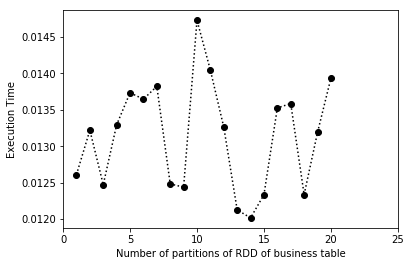

In [101]:
from numpy import array
times1 = array(times1)
plt.plot(range(1,21,1),times1,'ko:')
plt.xlim((0, 25))
plt.xlabel("Number of partitions of RDD of business table")
plt.ylabel("Execution Time")
#plt.ylim([0,8.5])
plt.show();

#### Experiment with more complex query with functions: groupBy(), count(), and sort() in business data set

In [104]:
times2 = []
for npart2 in range(1,21,1):
    business = business.repartition(npart2)
    print("Number of partitions: {}".format(business.rdd.getNumPartitions()))
    t0 = time.time()
    business.groupBy('city').count().sort('count', ascending=False).toPandas().head(10)
    dt = time.time() - t0;
    print("time: ",dt)
    times2 = times2 + [dt]

Number of partitions: 1
('time: ', 3.1228389739990234)
Number of partitions: 2
('time: ', 2.792872905731201)
Number of partitions: 3
('time: ', 1.9465579986572266)
Number of partitions: 4
('time: ', 1.912475824356079)
Number of partitions: 5
('time: ', 2.3053550720214844)
Number of partitions: 6
('time: ', 1.9967899322509766)
Number of partitions: 7
('time: ', 2.05855393409729)
Number of partitions: 8
('time: ', 2.050809144973755)
Number of partitions: 9
('time: ', 2.2086410522460938)
Number of partitions: 10
('time: ', 2.1508140563964844)
Number of partitions: 11
('time: ', 2.2865898609161377)
Number of partitions: 12
('time: ', 2.0131170749664307)
Number of partitions: 13
('time: ', 2.065850019454956)
Number of partitions: 14
('time: ', 2.125213861465454)
Number of partitions: 15
('time: ', 3.3551859855651855)
Number of partitions: 16
('time: ', 2.3378989696502686)
Number of partitions: 17
('time: ', 2.147265911102295)
Number of partitions: 18
('time: ', 2.160961151123047)
Number of 

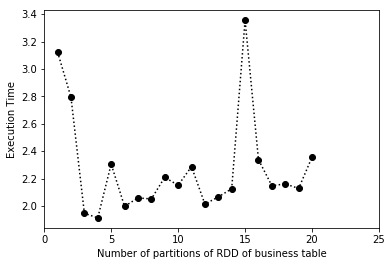

In [105]:
# refer to pyspark_rdd.ipynb in Week 3
from numpy import array
times2 = array(times2)
plt.plot(range(1,21,1),times2,'ko:')
plt.xlim((0, 25))
plt.xlabel("Number of partitions of RDD of business table")
plt.ylabel("Execution Time")
#plt.ylim([0,8.5])
plt.show();

#### Experiment with much more complex qeury with function: withColum(), and some calculations in review data set

In [106]:
# refer to pyspark_rdd.ipynb in Week 3
import time

times3 = []

for npart3 in range(11,21,1):
    review = review.repartition(npart3)
    print("Number of partitions: {}".format(review.rdd.getNumPartitions()))
    t0 = time.time()
    review_positive\
    .withColumn('percentage of positive reviews', (col('positive_reviews')/col('total_reviews'))*100)\
    .sort('percentage of positive reviews',ascending = False).toPandas().head(10)
    dt = time.time() - t0;
    print("time: ",dt)
    times3 = times3 + [dt]

Number of partitions: 11
('time: ', 56.946512937545776)
Number of partitions: 12
('time: ', 55.670791149139404)
Number of partitions: 13
('time: ', 55.05771613121033)
Number of partitions: 14
('time: ', 59.23739290237427)
Number of partitions: 15
('time: ', 55.03888821601868)
Number of partitions: 16
('time: ', 55.793827056884766)
Number of partitions: 17
('time: ', 62.86350893974304)
Number of partitions: 18
('time: ', 54.80619978904724)
Number of partitions: 19
('time: ', 56.22295093536377)
Number of partitions: 20
('time: ', 55.71577310562134)


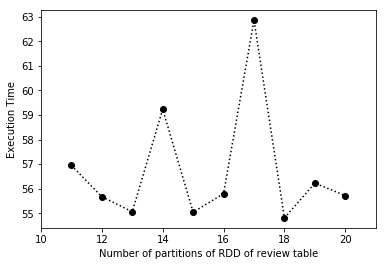

In [113]:
# refer to pyspark_rdd.ipynb in Week 3
from numpy import array
from matplotlib.pyplot import MultipleLocator
times3 = array(times3)
plt.plot(range(11,21,1),times3,'ko:')
plt.xlim((10, 21))
plt.xlabel("Number of partitions of RDD of review table")
plt.ylabel("Execution Time")
#plt.ylim([0,8.5])
plt.show();

#### Observations: 
Execution time for query does not decrease monotonically.

## 8. Conclusion

### 8.1 Limitations and improvements:

k for LDA model is constant 20 and the coherence measures can be implemented to find the optimal k value for LDA model with highest coherence score. Besides, different number of worker nodes can be implemented to examine how execution time to train LDA model interacts with number of worker nodes, to improve the efficiency of implementation of LDA model.

### 8.2 Conclusion of results:

In the first part, There are various categories of businesses in Yelp Dataset, from restaurants to Health & Medical and Restaurant has most number of businesses in Yelp Dataset. At the same time, businesses are located in different cities and different states. Further more, almost 76.75% businesses survive and many businesses are rated high with stars larger than 4. Yelp was founded in 2004 and the first user joined Yelp at 08:45:11 on 12 October, 2004. The number of users in Yelp increased rapidly from 2010 to 2017. However, number of users in Yelp increased slowly in 2020 and 2021, which might caused by the COVID-19. To adapt to the effects of COVID-19, businesses provides some extra services, such as virtual services and delivery services to operating businesses udner COVID-19. Interestingly, 

To do the sentiment analysis, LDA is implemented to extract hidden topics from text of positive reviews and negative reviews. Most of topics returned by LDA model for positive reviews are specific nouns, such as kebab and vermicelli, which does not contains the sentiment. It may indicate that kebab and vermicelli are popular food in the market. However, most of topics returned by LDA model for negative reviews has negative sentiment, such as disgusting and flavorless, which might means the food tastes bad for some restaurants. Compared with LDA model of positive reviews, topics returned by LDA model of negative reviews has an obvious negative sentiment, so there is difference between topics in positive reviews and negative reviews and topics can use to indicate the sentiment of reviews.

To examine how execution time interacts with number of partitions, query with different complexity executed in different data set with different numbers of partitions. There is no evidence that there is monotonic increase or decrease of execution time when numbers of partitions increase monotonically. If the number of partitions is small, then there is high volume of data in memory of one executor nodes. Therefore, computation speed might be unequal and slow. If there is too many partitions, then scheduling too many small tasks might affect the execution speed.


## 9. Reference


1.Yelp Dataset:
https://engineeringblog.yelp.com/2020/06/how-businesses-have-reacted-to-covid-19-using-yelp-features.html

2.Spark.apache:
https://spark.apache.org/docs/1.6.1/sql-programming-guide.html#inferring-the-schema-using-reflection

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.printSchema.html


3.Yelp-Sentiment-Analysis-and-data-management: 
https://github.com/SoniaRode21/Yelp-Sentiment-Analysis-and-data-management/blob/master/SentimentAnalysis/Code/Sentiment_Reviews.ipynb


4.NLP for Yelp Reviews:
https://www.kaggle.com/zhenyufan/nlp-for-yelp-reviews

5.Yelp Review Rating Prediction: Machine Learning and Deep Learning Models-Zefang Liu:
https://arxiv.org/abs/2012.06690

6.Latent Dirichlet Allocation-Si Chen and Yufei Wang-University of California San Diego

7.Sentiment Analysis with PySpark - Ricky Kim:
https://www.linkedin.com/pulse/sentiment-analysis-pyspark-ricky-kim

8.pyspark.ml package： 
https://spark.apache.org/docs/1.3.0/api/python/pyspark.ml.html

9.Using LDA to Uncover the Underlying Structures and Relations in Smart City Data Streams-Daniel Puschmann, Payam Barnaghi, Senior Member, IEEE, Rahim Tafazolli, Senior Member, IEEE
Institute for Communication Sy:
http://epubs.surrey.ac.uk/841381/1/Using%20LDA%20to%20Uncover%20the%20Underlying%20Structures%20and%20Relations%20in%20Smart%20City%20Data%20Streams.pdf
